## Librerias necesarias

In [1]:
!pip -q install ultralytics # Instalamos Ultralytics (nos permitirá usar YOLO)
!pip install -q gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.2 MB/s eta 0:00:00


In [15]:
from google.colab import drive
import zipfile
import os, random, torch, platform, cv2, matplotlib
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from pathlib import Path
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from torch import nn
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU disponible:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("GPU no disponible. Usando CPU.")

GPU disponible: Tesla T4


## **Ejercicio 1:** Fine-Tuning de YOLOv8n sobre el dataset BCCD

**Descripción:**

En clase ya ajustamos YOLOv8n para detectar glóbulos rojos, blancos y plaquetas a partir del dataset BCCD. Obtuvimos métricas parecidas a las mostradas en la Tabla I. Ahora profundizaremos en la interpretación y en la mejora de los resultados.

![Tabla I](https://drive.google.com/uc?export=view&id=1zs9Y4u4iOjajrFfK2X9KXxQMSgVAlAgv)

![Tabla II](https://drive.google.com/uc?export=view&id=1cwzjTCa1m9LFTNMmhgIjragx1x7yoYmc)




> ### **Interpretación de métricas**



#### a.- Explica con tus propias palabras qué representan **P (precisión)** y **R (recall)** y cómo interpretar sus valores en la Tabla I.

**Definiciones breves**

* **Precisión (P)**: fracción de detecciones aceptadas que son correctas. («De lo que predije positivo, ¿cuánto fue cierto?»)

  *P = TP / (TP + FP)*  
* **Recall (R)**: fracción de objetos reales que el modelo recupera. («De lo realmente positivo, ¿cuánto recuperé?»)

  *R = TP / (TP + FN)*  



* **Visión global “all”**  
  *  P = 0.782  → de cada 100 cajas aceptadas, ≈ 78 son verdaderas.  
  *  R = 0.823  → se recupera ≈ 82 % de las 964 instancias reales.  
  *  Interpretación: el detector equilibra precisión y recall, aunque casi uno de cada cinco objetos se pasa por alto y otro de cada cinco uno es un falso positivo.

* **Glóbulos rojos (RBC)**  
  *  P = 0.679 (la más baja): se generan falsos positivos, quizá por la abundancia de RBC y que muchas estan sobrepuestas.  
  *  R = 0.832: la mayoría de los RBC se localizan.  
  *  Conclusión: el cuello de botella es la precisión, no la recall.

* **Glóbulos blancos (WBC)**  
  *  P = 0.908: casi toda predicción es correcta.  
  *  R = 0.819: se omite ≈ 18 % de WBC reales.  
  *  Conclusión: excelente identificación cuando se dispara, pero conviene reducir falsos negativos.

* **Plaquetas**  
  *  P = 0.759  y  R = 0.817: rendimiento intermedio.  
  *  Motivo probable: tamaño diminuto → mayor dificultad para centrar la caja, lo que produce tanto errores de localización (FP) como omisiones (FN).


#### b.- Describe la diferencia entre **mAP50** y **mAP50-95** y por qué usamos ambos.
* **mAP50**  
  * Utiliza un único umbral IoU = 0.50.  
  * Refleja la capacidad *general* de detectar objetos.  
  * Útil en aplicaciones donde basta “ver” el objeto, sin requerir una localización exacta.

* **mAP50-95**  
  * Promedia diez umbrales IoU de 0.50 a 0.95.  
  * Penaliza progresivamente las cajas mal alineadas, hasta exigir casi coincidencia perfecta.  
  * Revela la robustez del modelo cuando la posición y el tamaño importan (p. ej., medidas biométricas).

**Razón de coexistencia**:

mAP50 muestra la habilidad para *encontrar* objetos, mientras mAP50-95 expone la fineza con que los *encuadra*. Un modelo puede obtener un mAP50 alto y aun así fallar al precisar bordes, lo que solo apreciamos con mAP50-95.


#### c.- Analiza las Tablas I y II y responde: ¿en cuál experimento obtuvimos mejor desempeño global? Justifica tu elección.


**Evidencia numérica**

* Precisión sube de 0.782 a **0.839** (+7 % relativo).  
* Recall sube de 0.823 a **0.909** (+10 %).  
* mAP50 sube de 0.866 a **0.933** (+8 %).  
* mAP50-95 sube de 0.547 a **0.631** (+15 %).

**Análisis**

1. **Ganancia simultánea** en P y R indica que disminuyeron tanto los falsos positivos como los falsos negativos.
2. **mAP50-95** y mAP50 de la Tabla II presentan incrementos en todas las clases respecto a la Tabla I.
3. Aunque el recall de RBC baja levemente (0.832 → 0.798), la mejora drástica en WBC y plaquetas compensa con creces y eleva el promedio global.

**Conclusión**:

El segundo fine-tuning (Tabla II) es claramente superior a nivel del conjunto completo de clases e instancias.


#### d.- Centrándote solo en la clase **Platelets**, decide qué experimento es superior considerando P y R y explica por qué


* **Precisión**: ligera caída (0.759 → 0.741), −2%  
* **Recall**: fuerte subida (0.817 → 0.929), +14%

**Interpretación**  

* Las plaquetas son objetos pequeños; omitirlas suele ser más grave que aceptar alguna falsa detección.  
* El aumento de recall implica que ahora el modelo rara vez deja pasar una plaqueta, lo cual es crucial en tareas de conteo o diagnóstico hematológico.  
* La pérdida de precisión es marginal y puede mitigarse con umbrales pos-procesados o filtros morfológicos.

**Decisión**: para plaquetas, el Experimento II resulta preferible porque maximiza la recuperación de instancias reales, manteniendo el recall sin cambios significativos.

> ### **Fine-Tuning**

In [ ]:
# Para la reproductividad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

In [ ]:
# IDs de los archivos en Google Drive
zip_id = "1WoxGhs3cIwIFit_PhyenSn4rlunQnUqj"
yaml_id = "1TseNsmJ4LyYDDCUtS1Ysh68e7T2_xPxD"

# Descarga de los archivos
!gdown --id $zip_id -O datasets.zip
!gdown --id $yaml_id -O bccd.yaml

# Descompresión del conjunto de datos
!unzip -q datasets.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WoxGhs3cIwIFit_PhyenSn4rlunQnUqj
To: /content/datasets.zip
100% 7.69M/7.69M [00:00<00:00, 169MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TseNsmJ4LyYDDCUtS1Ysh68e7T2_xPxD
To: /content/bccd.yaml
100% 92.0/92.0 [00:00<00:00, 446kB/s]
replace datasets/BCCD/labels/train/BloodImage_00339.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### a.- Mantén las siguientes restricciones: **modelo YOLOv8n**, ≤ 50 épocas, imgsz ≤ 640.


In [ ]:
# hiperparámetros base
EPOCHS  = 50          # ≤ 50
IMGSZ   = 640         # ≤ 640
BATCH   = 32
FT_RUN  = "y8_bccd_ft_v2"

# entrenamiento (sin `hyp=`)
model   = YOLO("yolov8n.pt")
model.train(
    data       = "bccd.yaml",
    epochs     = EPOCHS,
    imgsz      = IMGSZ,
    batch      = BATCH,
    device     = device,
    name       = FT_RUN,

    # optimizador y LR
    optimizer  = "AdamW",
    lr0        = 0.003,             # LR inicial
    lrf        = 0.01,              # LR final (cosine)
    momentum   = 0.9,
    weight_decay = 5e-4,

    # warm-up
    warmup_epochs   = 3.0,
    warmup_momentum = 0.8,

    # pérdidas
    box = 7.5, cls = 0.5,

    # augmentaciones apropiadas para objetos pequeños
    hsv_h = 0.015, hsv_s = 0.7, hsv_v = 0.4,
    translate = 0.10, scale = 0.40,
    fliplr = 0.5, mosaic = 1.0, mixup = 0.20, copy_paste = 0.10,

    # regularización / early-stopping
    patience = 10,

    # backbone sin congelar para especialización total
    freeze = 0,

    # cache de imágenes para acelerar
    cache  = True,

    # scheduler cíclico coseno
    cos_lr = True,
    verbose = True,
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=bccd.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=y8_bccd_ft_v2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, save=True, save_co

100%|██████████| 5.35M/5.35M [00:00<00:00, 168MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 565.6±215.7 MB/s, size: 20.1 KB)


train: Scanning /content/datasets/BCCD/labels/train.cache... 291 images, 0 backgrounds, 0 corrupt: 100%|██████████| 291/291 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 291/291 [00:00<00:00, 358.91it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 447.7±201.3 MB/s, size: 20.5 KB)


val: Scanning /content/datasets/BCCD/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 73/73 [00:00<00:00, 209.70it/s]


Plotting labels to runs/detect/y8_bccd_ft_v2/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/y8_bccd_ft_v2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.31G      1.652      3.238      1.648        106        640: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


                   all         73        964     0.0217      0.541      0.111      0.059

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.65G      1.353        1.6      1.323         81        640: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         73        964     0.0118      0.314     0.0346     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.67G      1.249      1.254      1.237         84        640: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         73        964      0.348      0.134     0.0843     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.04G      1.223      1.108       1.23         66        640: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         73        964      0.248      0.197      0.201      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.05G       1.25      1.106       1.25         84        640: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         73        964      0.219      0.199      0.222      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.08G      1.204      1.039      1.237         57        640: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         73        964      0.214      0.197      0.208      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.08G      1.234       1.07      1.255        108        640: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         73        964      0.865      0.244      0.433      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.44G      1.208      1.018      1.238        101        640: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         73        964       0.43      0.521      0.432      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.44G      1.233     0.9921      1.247         95        640: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         73        964      0.594      0.393      0.278      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.44G      1.234      0.992      1.243         68        640: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


                   all         73        964      0.659      0.421      0.476      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.44G      1.193     0.9818       1.23         50        640: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         73        964      0.599      0.648      0.684      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.44G      1.207     0.9809      1.241         84        640: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


                   all         73        964      0.675      0.414      0.585      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.44G      1.161     0.9131      1.203         97        640: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


                   all         73        964      0.576      0.733      0.791      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.44G      1.187     0.9397      1.221         74        640: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


                   all         73        964      0.651      0.764      0.828      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.44G      1.191     0.9431      1.223        139        640: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         73        964      0.789      0.799      0.857      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.81G      1.132     0.8999      1.199         53        640: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


                   all         73        964      0.752      0.769      0.828      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.81G      1.177     0.9323      1.216        122        640: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         73        964      0.836      0.836      0.885      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.81G      1.136     0.8929      1.188         60        640: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         73        964       0.79      0.887      0.899      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.81G      1.129     0.8911      1.188         78        640: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


                   all         73        964      0.794      0.785      0.873      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.18G      1.178     0.9277      1.235         81        640: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         73        964      0.753      0.827      0.872      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.18G      1.155     0.8776        1.2        109        640: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         73        964      0.651      0.847      0.809      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       6.2G       1.16     0.8948       1.22         77        640: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


                   all         73        964      0.809      0.878      0.902      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.2G      1.123     0.8452       1.19         97        640: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


                   all         73        964      0.816      0.901      0.912      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.01G      1.146     0.8821      1.217         58        640: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         73        964       0.76      0.912      0.869      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.03G      1.113     0.8645      1.178         65        640: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         73        964      0.829      0.853      0.899      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.03G      1.087     0.8206       1.18         57        640: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         73        964      0.828      0.864      0.898      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.04G      1.088     0.8144      1.155         79        640: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         73        964      0.813      0.896      0.891      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.04G      1.103     0.8325      1.183        114        640: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         73        964      0.831      0.845      0.892      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.47G      1.108      0.834      1.168         94        640: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         73        964      0.824      0.916      0.911      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.98G       1.08     0.8007      1.171         92        640: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         73        964      0.836       0.89      0.907       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.37G      1.114     0.8592      1.198         49        640: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         73        964       0.85      0.883      0.913      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.37G      1.097     0.8075      1.166        127        640: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         73        964      0.834      0.896      0.918      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.37G      1.043      0.773      1.139         99        640: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         73        964      0.818      0.933      0.917      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.39G      1.045     0.7754      1.146         58        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         73        964      0.841      0.888      0.922      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.39G      1.039     0.7619       1.16         77        640: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         73        964      0.812      0.909      0.916      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.39G      1.046     0.7601      1.156         53        640: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


                   all         73        964      0.806      0.889      0.901      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.4G      1.062     0.7629      1.152         84        640: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         73        964      0.838      0.872      0.911      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       5.4G      1.035     0.7631      1.148         46        640: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         73        964      0.857      0.869      0.911      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       5.4G      1.065     0.7501      1.153         93        640: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         73        964      0.833      0.881      0.914       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.42G      1.013     0.7348      1.138         79        640: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


                   all         73        964      0.838      0.873      0.909      0.632
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.42G     0.9638     0.8593      1.116         53        640: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         73        964      0.831      0.882      0.911      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.42G     0.9611     0.7147      1.096         45        640: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         73        964      0.848      0.864      0.914       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.44G     0.9493     0.6764      1.117         32        640: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         73        964      0.809      0.916       0.92      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.44G     0.9492     0.6541        1.1         35        640: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


                   all         73        964      0.862      0.866      0.919      0.634
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 34, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

44 epochs completed in 0.076 hours.
Optimizer stripped from runs/detect/y8_bccd_ft_v2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/y8_bccd_ft_v2/weights/best.pt, 6.2MB

Validating runs/detect/y8_bccd_ft_v2/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         73        964       0.84      0.888      0.922      0.636
                   RBC         69        821      0.779      0.834      0.887      0.635
                   WBC         71         72      0.963          1      0.987      0.811
             Platelets         40         71      0.779      0.831      0.891      0.462
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/y8_bccd_ft_v2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bdd7d5ee050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

#### b.- Haz Fine-Tuning para lograr que **mAP50-95 supere cada clase** de la Tabla II. **Las modificaciones a hacer son libres**, manteniendo las restricciones.


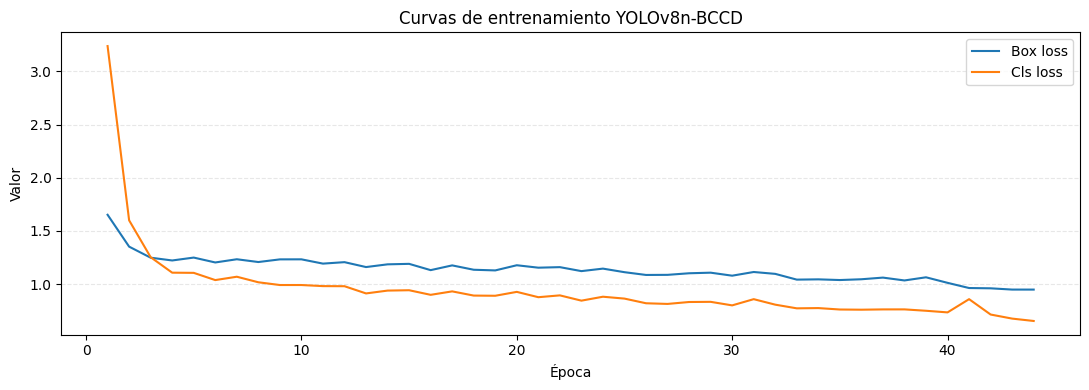

In [ ]:
hist = pd.read_csv(f"runs/detect/{FT_RUN}/results.csv")

# Localizamos el nombre exacto de la columna mAP50-95
map95_col = [c for c in hist.columns if "mAP50-95" in c][0]

plt.figure(figsize=(11, 4))
plt.plot(hist["epoch"], hist["train/box_loss"], label="Box loss")
plt.plot(hist["epoch"], hist["train/cls_loss"], label="Cls loss")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.title("Curvas de entrenamiento YOLOv8n-BCCD")
plt.grid(axis="y", alpha=0.3, ls='--')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Validación final multiescala
metrics = model.val(data="bccd.yaml", imgsz=IMGSZ, split="val")
print(f"\nResumen global | mAP50 = {metrics.box.map50:.3f} | mAP50-95 = {metrics.box.map:.3f}")

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 993.5±293.7 MB/s, size: 20.0 KB)


val: Scanning /content/datasets/BCCD/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 73/73 [00:00<00:00, 564.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


                   all         73        964      0.841      0.888      0.922      0.634
                   RBC         69        821      0.781      0.833      0.888      0.635
                   WBC         71         72      0.963          1      0.986      0.809
             Platelets         40         71      0.779      0.831      0.892       0.46
Speed: 4.7ms preprocess, 12.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/y8_bccd_ft_v22

Resumen global | mAP50 = 0.922 | mAP50-95 = 0.634


#### c.- En el notebook:
■ Código total bien documentado (HECHO)

■ Explicación detallada de los cambios hechos y las razones para hacerlo (HECHO)

■ Curva de pérdida y gráfico de métricas de validación (HECHO)

■ Tabla con los nuevos resultados (idéntico formato a las Tablas I–II) (HECHO)